Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Summary

This document contains the code of the regularized evolution (i.e. aging evolution) algorithm used in:

[E. Real, A. Aggarwal, Y. Huang, and Q. V. Le 2018. Regularized Evolution for Image Classifier Architecture Search](https://arxiv.org/abs/1802.01548).

It demonstrates the application of the algorithm in a toy search space that can be run quickly in a single machine.

# Toy Search Space

For a simple problem to use for illustration purposes, we use the toy search space of appendix C. In it, toy models have a simulated architecture (bit-string) and a simulated accuracy (the number of 1s in the bit-string, with some additional random noise), as described below.

In [1]:
DIM = 100  # Number of bits in the bit strings (i.e. the "models").
NOISE_STDEV = 0.01  # Standard deviation of the simulated training noise.

class Model(object):
  """A class representing a model.
  
  It holds two attributes: `arch` (the simulated architecture) and `accuracy`
  (the simulated accuracy / fitness). See Appendix C for an introduction to
  this toy problem.
  
  In the real case of neural networks, `arch` would instead hold the
  architecture of the normal and reduction cells of a neural network and
  accuracy would be instead the result of training the neural net and
  evaluating it on the validation set.
  
  We do not include test accuracies here as they are not used by the algorithm
  in any way. In the case of real neural networks, the test accuracy is only
  used for the purpose of reporting / plotting final results.

  In the context of evolutionary algorithms, a model is often referred to as
  an "individual".

  Attributes:
    arch: the architecture as an int representing a bit-string of length `DIM`.
        As a result, the integers are required to be less than `2**DIM`. They
        can be visualized as strings of 0s and 1s by calling `print(model)`,
        where `model` is an instance of this class.
    accuracy:  the simulated validation accuracy. This is the sum of the
        bits in the bit-string, divided by DIM to produce a value in the
        interval [0.0, 1.0]. After that, a small amount of Gaussian noise is
        added with mean 0.0 and standard deviation `NOISE_STDEV`. The resulting
        number is clipped to within [0.0, 1.0] to produce the final validation
        accuracy of the model. A given model will have a fixed validation
        accuracy but two models that have the same architecture will generally
        have different validation accuracies due to this noise. In the context
        of evolutionary algorithms, this is often known as the "fitness".
  """
  def __init__(self):
    self.arch = None
    self.accuracy = None
    
  def __str__(self):
    """Prints a readable version of this bitstring."""
    return '{0:b}'.format(self.arch)
  
def train_and_eval(arch):
  """Simulates training and evaluation.
  
  Computes the simulated validation accuracy of the given architecture. See
  the `accuracy` attribute in `Model` class for details.
  
  Args:
    arch: the architecture as an int representing a bit-string.
  """
  accuracy =  float(_sum_bits(arch)) / float(DIM)
  accuracy += random.gauss(mu=0.0, sigma=NOISE_STDEV)
  accuracy = 0.0 if accuracy < 0.0 else accuracy
  accuracy = 1.0 if accuracy > 1.0 else accuracy
  return accuracy

def _sum_bits(arch):
  """Returns the number of 1s in the bit string.
  
  Args:
    arch: an int representing the bit string.
  """
  total = 0
  for _ in range(DIM):
    total += arch & 1
    arch = (arch >> 1)
  return total

# Search Space Traversal

Below we define a function to generate random architectures in the basic search space and a function to mutate architectures within the search space.

In [2]:
import random

def random_architecture():
  """Returns a random architecture (bit-string) represented as an int."""
  return random.randint(0, 2**DIM - 1)

def mutate_arch(parent_arch):
  """Computes the architecture for a child of the given parent architecture.

  The parent architecture is cloned and mutated to produce the child
  architecture. The child architecture is mutated by flipping a randomly chosen
  bit in its bit-string.

  Args:
    parent_arch: an int representing the architecture (bit-string) of the
        parent.

  Returns:
    An int representing the architecture (bit-string) of the child.
  """
  position = random.randint(0, DIM - 1)  # Index of the bit to flip.
  
  # Flip the bit at position `position` in `child_arch`.
  child_arch = parent_arch ^ (1 << position)
  
  return child_arch

# Regularized Evolution Algorithm

The regularized evolution (i.e. aging evolution) algorithm can be written as:

In [3]:
import collections
import random

def regularized_evolution(cycles, population_size, sample_size):
  """Algorithm for regularized evolution (i.e. aging evolution).
  
  Follows "Algorithm 1" in Real et al. "Regularized Evolution for Image
  Classifier Architecture Search".
  
  Args:
    cycles: the number of cycles the algorithm should run for.
    population_size: the number of individuals to keep in the population.
    sample_size: the number of individuals that should participate in each
        tournament.

  Returns:
    history: a list of `Model` instances, representing all the models computed
        during the evolution experiment.
  """
  population = collections.deque()
  history = []  # Not used by the algorithm, only used to report results.

  # Initialize the population with random models.
  while len(population) < population_size:
    model = Model()
    model.arch = random_architecture()
    model.accuracy = train_and_eval(model.arch)
    population.append(model)
    history.append(model)

  # Carry out evolution in cycles. Each cycle produces a model and removes
  # another.
  while len(history) < cycles:
    # Sample randomly chosen models from the current population.
    sample = []
    while len(sample) < sample_size:
      # Inefficient, but written this way for clarity. In the case of neural
      # nets, the efficiency of this line is irrelevant because training neural
      # nets is the rate-determining step.
      candidate = random.choice(list(population))
      sample.append(candidate)

    # The parent is the best model in the sample.
    parent = max(sample, key=lambda i: i.accuracy)

    # Create the child model and store it.
    child = Model()
    child.arch = mutate_arch(parent.arch)
    child.accuracy = train_and_eval(child.arch)
    population.append(child)
    history.append(child)

    # Remove the oldest model.
    population.popleft()

  return history, population

# Example Run on the Toy Search Space

We run the algorithm for 1000 samples, setting the population size and sample size parameters to reasonable values.

In [11]:
history, population = regularized_evolution(
    cycles=15000, population_size=100, sample_size=10)
max(population, key=lambda i : i.accuracy).accuracy

0.9966293333336671

We plot the progress of the experiment, showing how the accuracy improved gradually:

/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/erick/anaconda3/envs/env1/lib/python3.7/

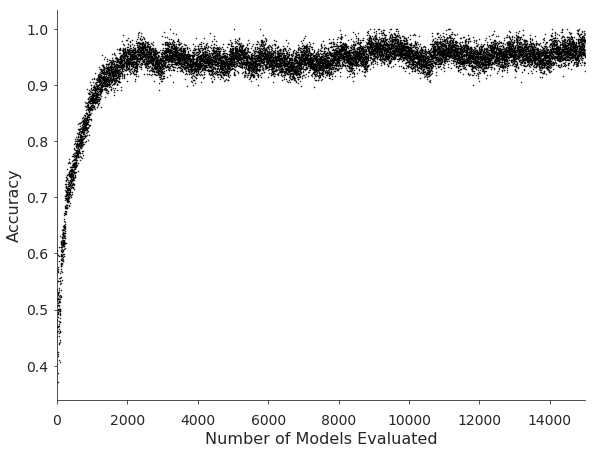

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style('white')
xvalues = range(len(history))
yvalues = [i.accuracy for i in history]
ax = plt.gca()
ax.scatter(
    xvalues, yvalues, marker='.', facecolor=(0.0, 0.0, 0.0),
    edgecolor=(0.0, 0.0, 0.0), linewidth=1, s=1)
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.tight_layout()
ax.tick_params(
    axis='x', which='both', bottom='True', top='False', labelbottom='True',
    labeltop='False', labelsize=14, pad=10)
ax.tick_params(
    axis='y', which='both', left='True', right='False', labelleft='True',
    labelright='False', labelsize=14, pad=5)

plt.xlabel('Number of Models Evaluated', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlim(0, len(history))
sns.despine()

In [15]:
import time
from datetime import timedelta

start_time = time.time()

s = 0.0
for _ in range(100):
    _, population = regularized_evolution(cycles=4000, population_size=100, sample_size=10)
    s += max(population, key=lambda i: i.accuracy).accuracy
print(s/100)

elapsed_time_secs = time.time() - start_time

msg = "Execution took: %s (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))

print(msg)    

0.9851150604074221
Execution took: 0:00:47 (Wall clock time)
